In [1]:
# Import all necessary packages
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

# <center>Reading Yelp Dataset</center>

In [2]:
ratings_df = pd.read_csv("Yelp\\ratings.csv").drop(columns=['Date'])

# <center>Splitting the Dataset</center>

In [3]:
# Next, we split the Yelp dataset into a train and test set
# 80% will be used for training
# 20% will be used for testing
train_lst,test_lst = train_test_split(ratings_df, test_size=0.2,random_state=42)

#Since the train_test_split() function returns lists,
#I'm converting to dataframes to make it easier to work with
train_df = pd.DataFrame(train_lst)
test_df = pd.DataFrame(test_lst)

In [4]:
train_df.head()

,User ID,Business ID,Rating
13033,4027,397,4
12113,3374,608,3
21100,5040,220,5
20763,6884,799,5
4438,948,686,2


In [5]:
test_df.head()

,User ID,Business ID,Rating
21643,7280,450,5
17597,3547,83,3
29819,9022,1395,5
29342,8229,333,1
11453,3400,1089,5


# <center>Finding Global Mean of Training Data</center>

In [6]:
# Calculate global mean of train set.
# It's computed by taking the arithmetic 
# average of all ratings in the training set.

global_mean = train_df["Rating"].mean()

print('The global mean is',round(global_mean,3))

The global mean is 3.598


In [7]:
# Create 2 seperate dataframes: 1 for user deviation and 1 for item deviation
# Pick random values for user deviation and item deviation.
user_dev = train_df.copy()
user_dev = user_dev.drop(columns=['Business ID','Rating'])
user_dev = user_dev.drop_duplicates()
user_dev = user_dev.set_index('User ID')
user_dev['Deviation'] = np.random.uniform(-1,3,size= len(user_dev))
display(user_dev.head())

item_dev = train_df.copy()
item_dev = item_dev.drop(columns=['User ID','Rating'])
item_dev = item_dev.drop_duplicates()
item_dev = item_dev.set_index('Business ID')
item_dev['Deviation'] = np.random.uniform(-1,3,size=len(item_dev))
display(item_dev.head())

,Deviation
User ID,
4027,1.815095
3374,1.563212
5040,0.820927
6884,-0.361854
948,2.677522


,Deviation
Business ID,
397,1.822385
608,-0.914658
220,-0.446940
799,1.647917
686,2.736282


# <center>Creating Residual Function</center>
<center>Residual = observed rating - predicted rating</center>

<center>Predicted Rating is obtained using the following formula: </center><br>

<center>$\hat{r}_{ui} = \mu + b_{u} +  b_{i}$ </center><br>
<center>$\hat{r}_{ui}$ = predicted rating for user u on item i </center><br>
<center>$\mu$ = global_mean </center><br>
<center>$b_{u}$ = user u's average rating deviation from global_mean </center><br>
<center>$b_{i}$ = item i's average rating deviation from global_mean </center><br>

In [8]:
def calculate_residual(train_df, item_dev, user_dev, global_mean):
    train_df = train_df.set_index(pd.Series(range(train_df.shape[0])))
    train_df["Predicted"]= float('nan')
    
    for i in range(0,len(train_df)):
        bu = 0 
        bi = 0     
        
        if train_df.loc[i,'User ID'] in user_dev.index:
            bu = user_dev.loc[train_df.loc[i,'User ID'],'Deviation']
        else:
            continue
            
        if train_df.loc[i,'Business ID'] in item_dev.index:
            bi = item_dev.loc[train_df.loc[i,'Business ID'], 'Deviation'] 
        else:
            continue
            
        train_df.loc[i,'Predicted'] = global_mean + bu + bi
        
    train_df["Residual"]=train_df["Rating"]-train_df["Predicted"]  
    
    return train_df

# <center>Creating Loss Function</center>
<center>$f(b_{u},b_{i}) = \sum_{(u,i)\in K}(\hat{r}_{ui} - \mu - b_{u} -  b_{i})^{2} + \lambda(\sum_{u} b_{u}^{2} + \sum_{i} b_{i}^{2})$ </center><br>

<center>Where $\hat{r}_{ui}$ is the observed rating in the training set K. </center>

In [9]:
def loss_function(trainData,userDev,itemDev,lamb):
    result = trainData['Residual'].pow(2).sum() + lamb * (userDev['Deviation'].pow(2).sum() + itemDev['Deviation'].pow(2).sum())  
    
    return round(result,2)

In [10]:
def bu_deviation(user_dev, train_df, learning_rate, lamb):
    for i in range(0,len(train_df)):
        b_u = user_dev.loc[train_df.loc[i,'User ID'],'Deviation']
        e_ui=train_df.loc[i,'Residual']
        user_dev.at[train_df.loc[i,'User ID'], 'Deviation'] = b_u-(learning_rate*(-2*e_ui+2*lamb*b_u))
    
    return user_dev

In [11]:
def bi_deviation(item_dev, train_df, learning_rate, lamb):
    for i in range(0,len(train_df)):
        b_i = item_dev.loc[train_df.loc[i,'Business ID'],'Deviation']
        e_ui=train_df.loc[i,'Residual']
        item_dev.at[train_df.loc[i,'Business ID'], 'Deviation'] = b_i-(learning_rate*(-2*e_ui+2*lamb*b_i))
    
    return item_dev

# <center>__Setting the Learning Rate__
When updating the deviation for each user and item, it's important to choose a learning rate that's just right. We don't want it to be too large or too small because it will negativly impact the performance of our model. If you try changing the learning rate to 0.1, you can actually see how it increases the result of the loss function which is NOT what we want. I found that using 0.001 learning rate worked great. </center>

# <center>Here's What a Large Learning Rate Looks Like...</center>
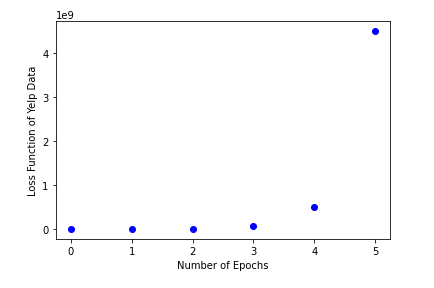

<center>You can test this out by changing the learning_rate variable below.</center>

In [12]:
learning_rate = 0.001

# <center>Setting the Lambda</center>

<center>Lambda has to be just right to avoid overfitting and underfitting the data. </center>


In [13]:
lamb = 0.5

# <center>Time for Epochs!</center>

<center>1 Epoch = 1 complete pass through training data.</center>

In [14]:
epochs = 5

# Loss is a list that stores the result of loss function at the end of each epoch
loss = []

train_df = calculate_residual(train_df,item_dev,user_dev,global_mean)
loss.append(loss_function(train_df, user_dev,item_dev,lamb))

for i in range(0, 5):
    user_dev = bu_deviation(user_dev,train_df,learning_rate,lamb)
    item_dev = bi_deviation(item_dev,train_df,learning_rate,lamb)
    train_df = calculate_residual(train_df,item_dev,user_dev,global_mean)
    loss.append(loss_function(train_df,user_dev,item_dev,lamb))

# <center>Graphing Results of Epochs</center>

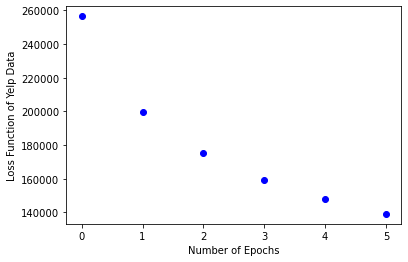

In [15]:
x_axis = loss
y_axis = [x for x in range(len(x_axis))]

plt.plot(y_axis,x_axis, "bo")
plt.ylabel("Loss Function of Yelp Data")
plt.xlabel("Number of Epochs")
plt.show()

# <center>Calculating the Mean Absolute Error</center>

In [16]:
# Calculate Residual between test and the train deviations
test_df = calculate_residual(test_df,item_dev,user_dev, global_mean)

sum = test_df["Residual"].apply(lambda x: abs(x)).sum()

print(round(sum/len(test_df),3))

1.236
